In [229]:
import pandas as pd

In [230]:
bitcoin = pd.read_csv('datasets/coin_Bitcoin.csv')
bitcoin.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [231]:
bitcoin.tail()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11
2990,2991,Bitcoin,BTC,2021-07-06 23:59:59,35038.536363,33599.916169,33723.509655,34235.193451,2.650126e+10,6.418992e+11


In [232]:
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
bitcoin.set_index('Date', inplace=True)
bitcoin.index.freq = 'D'
bitcoin.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


<Axes: xlabel='Date'>

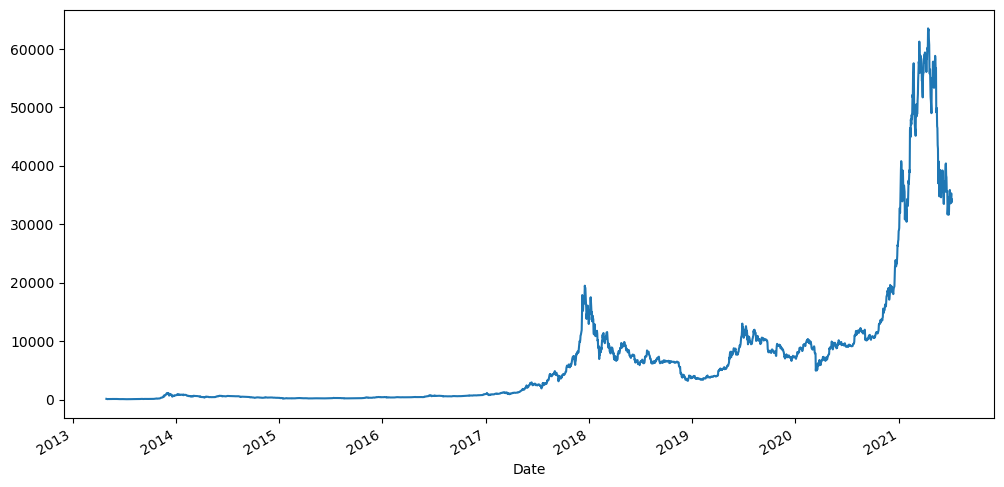

In [233]:
bitcoin['Close'].plot(figsize=(12, 6))

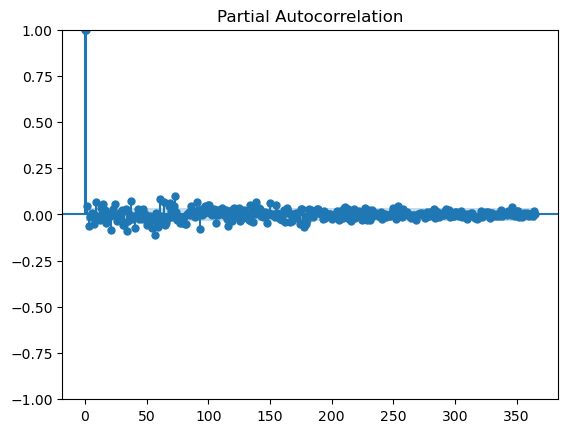

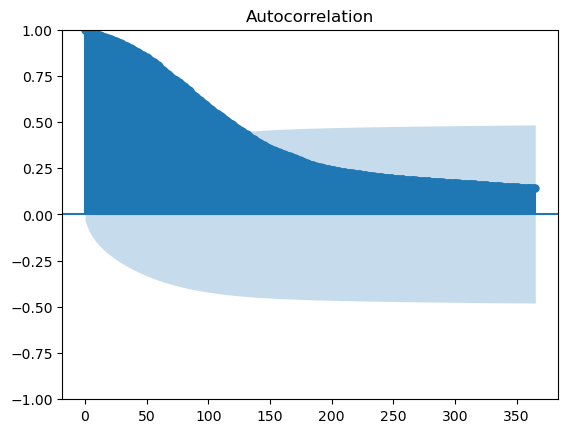

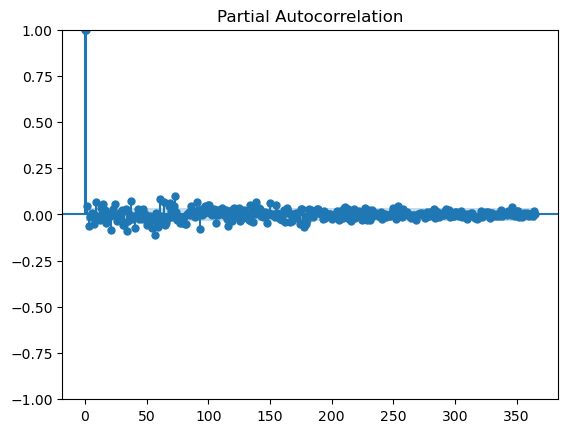

In [234]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin['Close'], lags=365)
plot_pacf(bitcoin['Close'], lags=365)

In [235]:
bitcoin_lagged = bitcoin[['Close']].copy()
for i in range(180,0,-1):
    bitcoin_lagged['t='+str(i)] = bitcoin_lagged['Close'].shift(i)
bitcoin_lagged.dropna(inplace=True)
bitcoin_lagged.head()

C:\Users\mwdzi\AppData\Local\Temp\ipykernel_17340\420268033.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bitcoin_lagged['t='+str(i)] = bitcoin_lagged['Close'].shift(i)
C:\Users\mwdzi\AppData\Local\Temp\ipykernel_17340\420268033.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bitcoin_lagged['t='+str(i)] = bitcoin_lagged['Close'].shift(i)
C:\Users\mwdzi\AppData\Local\Temp\ipykernel_17340\420268033.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

,Close,t=180,t=179,t=178,t=177,t=176,t=175,t=174,t=173,t=172,...,t=10,t=9,t=8,t=7,t=6,t=5,t=4,t=3,t=2,t=1
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-26 23:59:59,177.320007,144.539993,139.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,...,142.550003,146.250000,155.960007,172.419998,174.610001,182.210007,193.759995,213.619995,198.229996,186.690002
2013-10-27 23:59:59,196.440002,139.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,...,146.250000,155.960007,172.419998,174.610001,182.210007,193.759995,213.619995,198.229996,186.690002,177.320007
2013-10-28 23:59:59,198.550003,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,...,155.960007,172.419998,174.610001,182.210007,193.759995,213.619995,198.229996,186.690002,177.320007,196.440002
2013-10-29 23:59:59,204.389999,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,...,172.419998,174.610001,182.210007,193.759995,213.619995,198.229996,186.690002,177.320007,196.440002,198.550003
2013-10-30 23:59:59,199.970001,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,...,174.610001,182.210007,193.759995,213.619995,198.229996,186.690002,177.320007,196.440002,198.550003,204.389999


In [236]:
train = bitcoin_lagged.iloc[:-30]
test = bitcoin_lagged.iloc[-30:]

In [237]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = train.drop('Close', axis=1)
y = train['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [238]:
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [239]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)*100

2.8169232782727818

In [240]:
import numpy as np


def make_predictions(test_data, model):
    n = len(test_data)
    X_test = test_data.drop('Close', axis=1)
    test_prediction_rfr = []
    for i in range(n):
        batch = pd.DataFrame(X_test.iloc[i].values.reshape(1, -1), columns=X_test.columns)
        y_pred = model.predict(batch)[0]
        test_prediction_rfr.append(y_pred)

    return test_prediction_rfr



test_prediction_rfr = make_predictions(test, model)

In [241]:
mean_absolute_percentage_error(test['Close'], test_prediction_rfr)*100

4.99710217088916

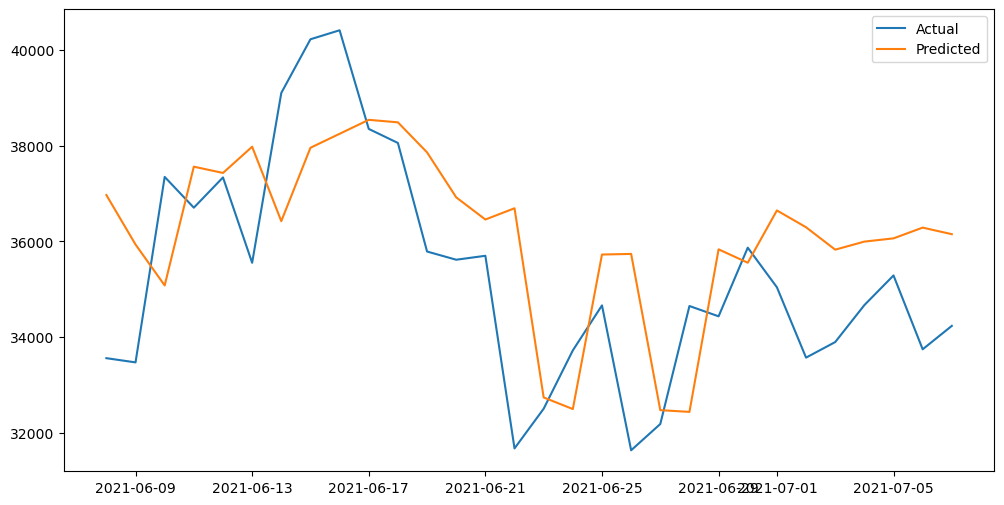

In [242]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, test_prediction_rfr, label='Predicted')
plt.legend()
plt.show()